In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.api as smg
import scipy
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error


np.random.seed(0)

In [2]:
# https://www.kaggle.com/datasets/mohansacharya/graduate-admissions?resource=download&select=Admission_Predict_Ver1.1.csv

In [3]:
df = pd.read_csv("./datasets/Admission_Predict_Ver1.1.csv")

columns = ["GRE Score", "TOEFL Score", "University Rating", "SOP", "LOR ", "CGPA"]
target_col = "Chance of Admit "

df[columns + [target_col]]

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Chance of Admit
0,337,118,4,4.5,4.5,9.65,0.92
1,324,107,4,4.0,4.5,8.87,0.76
2,316,104,3,3.0,3.5,8.00,0.72
3,322,110,3,3.5,2.5,8.67,0.80
4,314,103,2,2.0,3.0,8.21,0.65
...,...,...,...,...,...,...,...
495,332,108,5,4.5,4.0,9.02,0.87
496,337,117,5,5.0,5.0,9.87,0.96
497,330,120,5,4.5,5.0,9.56,0.93
498,312,103,4,4.0,5.0,8.43,0.73


In [4]:
print(f'{"="*20} Dane nie zawierają wartości brakujących, jak widać poniżej, więc nie wykonujemy żadnych `imputacji` danych {"="*20}')
df.isna().sum()

==================== Dane nie zawierają wartości brakujących, jak widać poniżej, więc nie wykonujemy żadnych `imputacji` danych ====================


Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [5]:
def display_data(df):
    df.hist(figsize=(15,8))

==================== Data (X) distribution ====================


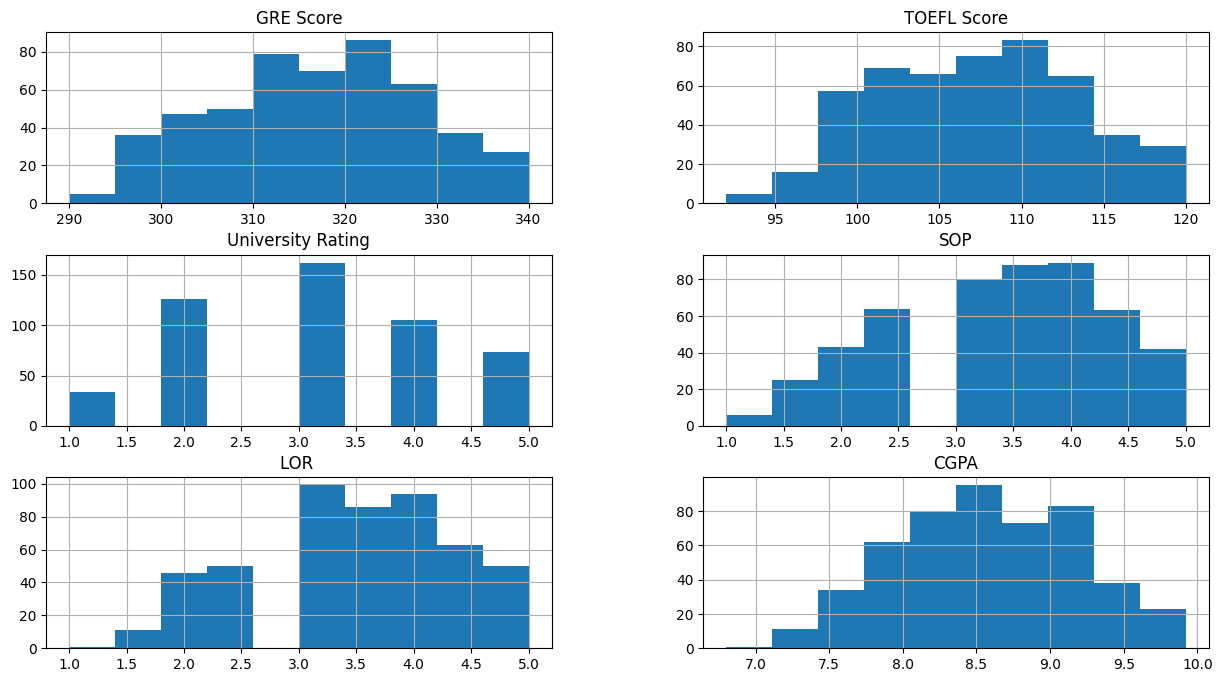

In [6]:
print(f"{"="*20} Data (X) distribution {"="*20}")
display_data(df[columns])

==================== Feature to predict (y) distribution ====================


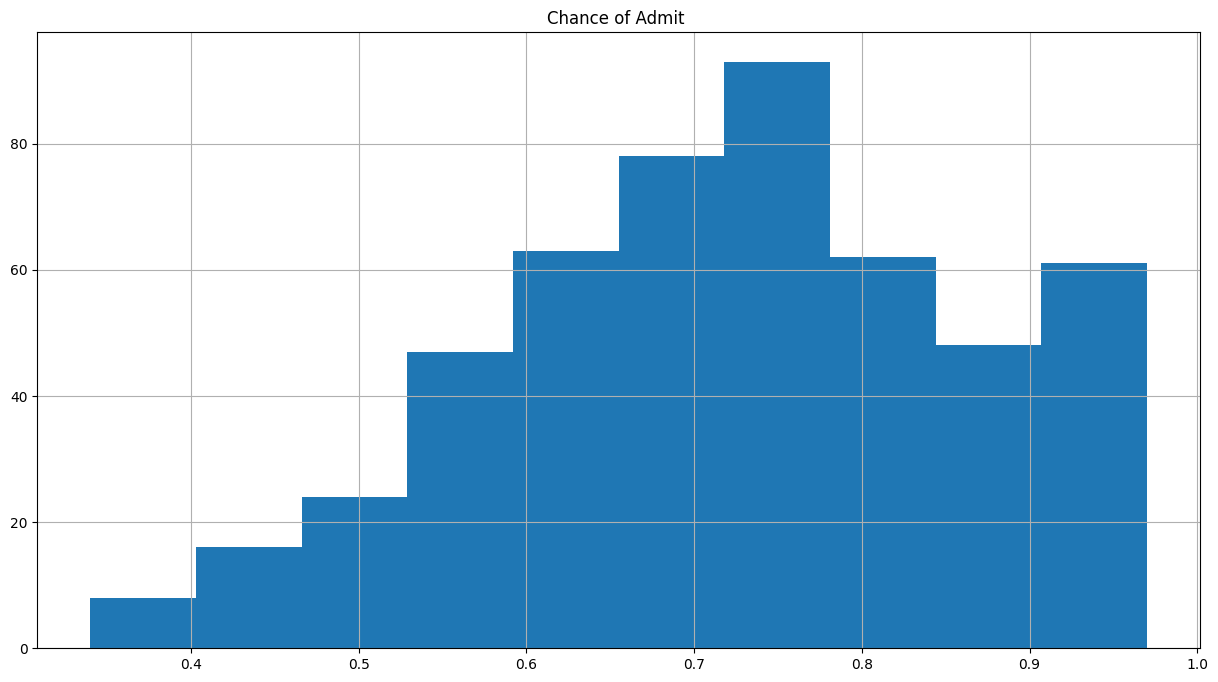

In [7]:
print(f"{"="*20} Feature to predict (y) distribution {"="*20}")
display_data(df[[target_col]])

In [8]:
def plot_corr(df):
    plt.figure(figsize=(10, 8))
    corr_matrix = np.corrcoef(df.values.T)
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", xticklabels=columns, yticklabels=columns, cmap='coolwarm')

==================== Data (X) correlation matrix ====================


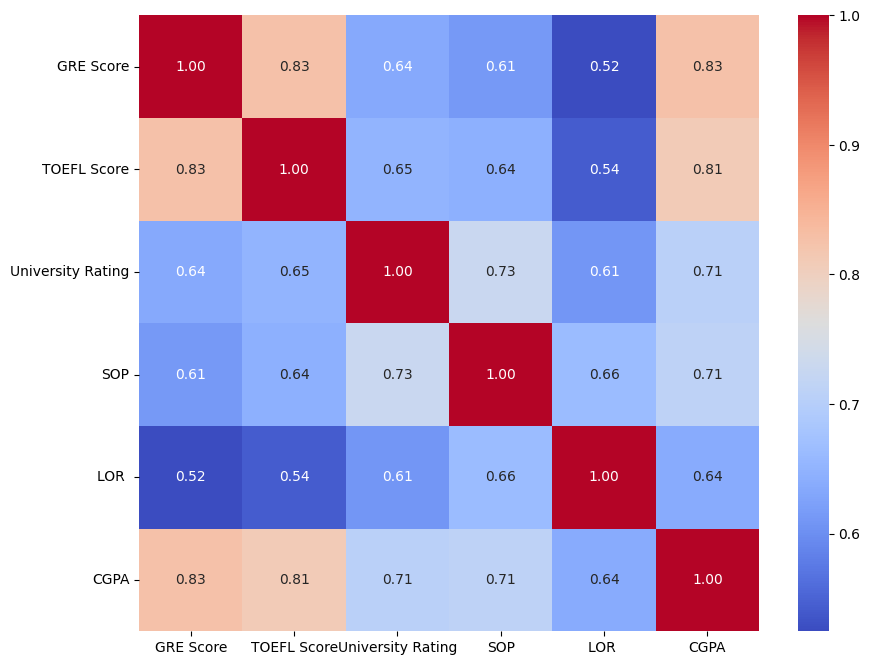

In [9]:
print(f"{"="*20} Data (X) correlation matrix {"="*20}")
plot_corr(df[columns])

In [10]:
def build_and_analyze_model(df, x_col, y_col):
    X = sm.add_constant(df[x_col])
    y = df[y_col]

    model = sm.OLS(y, X)
    model_results = model.fit()

    print(f"\n\n{"="*10} Correlation: {"="*10}\n")
    target_correlation = df[columns + [target_col]].corr()[target_col].sort_values(ascending=False)
    print(f'Pearson correlation coefficient between X and y: {target_correlation}')
    print("="*60)
    
    print(f"\n\n{"="*10} Model summary description: {"="*10}")
    print(model_results.summary())
    print("="*60)
    
    residuals = model_results.resid
    fitted_values = model_results.fittedvalues

    print(f"\n\n{"="*10} Metrics: {"="*10}")
    rss = np.sum(residuals ** 2)
    mse = np.mean(residuals ** 2)
    rmse = np.sqrt(mse)
    print(f'Residuals Sum Squares (RSS): {rss}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print("="*60)

    print(f"\n\n{"="*10} Residuals statistics description: {"="*10}")
    display(residuals.describe())
    print("="*60)

    fig, ax = plt.subplots(3, 3, figsize=(18, 18))
    ax = ax.flatten()

    target_correlation.plot.bar(title="Target Correlation", ax=ax[0])

    sns.histplot(residuals, kde=True, ax=ax[1])
    ax[1].set_title('Histogram residuals')
    
    scipy.stats.probplot(residuals, dist="norm", plot=ax[2])
    ax[2].set_title('Q-Q plot residuals')

    ax[3].scatter(fitted_values, residuals, edgecolors='k', facecolors='none')
    ax[3].axhline(0, color='gray', linestyle='dashed', linewidth=2)
    ax[3].set_title("Residuals vs fitted")
    ax[3].set_xlabel("Fitted values")
    ax[3].set_ylabel("Residuals")
    z = sm.nonparametric.lowess(residuals, fitted_values)
    ax[3].plot(z[:, 0], z[:, 1], color='red', lw=2)


    sqrt_standardized_residuals = np.sqrt(np.abs(residuals / np.std(residuals)))
    ax[4].scatter(fitted_values, sqrt_standardized_residuals, edgecolors='k', facecolors='none')
    z = sm.nonparametric.lowess(sqrt_standardized_residuals, fitted_values)
    ax[4].plot(z[:, 0], z[:, 1], color='red', lw=2)
    ax[4].set_title("Scale-location")
    ax[4].set_xlabel("Fitted values")
    ax[4].set_ylabel("√|Standardized residuals|")


    cooks_d = model_results.get_influence().cooks_distance[0]
    outlier_cooks_threshold = (4 / (cooks_d.size - 1))
    outliers_cooks_d = np.where(cooks_d > outlier_cooks_threshold)[0]
    ax[5].plot(cooks_d, 'bo', linestyle='None')
    ax[5].axhline(outlier_cooks_threshold, color='red', linestyle='dashed', label=f"Threshold: {outlier_cooks_threshold}")
    ax[5].set_title("Cook's Distance")
    ax[5].set_xlabel("Observation Index")
    ax[5].set_ylabel("Cook's Distance")

    standardized_residuals = np.abs(residuals / np.std(residuals))
    ax[6].boxplot(standardized_residuals)
    ax[6].set_title('Boxplot of Standardized Residuals')
    ax[6].set_ylabel('Standardized Residuals')

    # Wartości odstające i wpływowe
    sm.graphics.influence_plot(model_results, criterion="cooks", ax=ax[7])
    
    
    print(f"\n\n{"="*10} Residual normality check: {"="*10}")
    print("Shapiro-Wilk test p-value:", scipy.stats.shapiro(residuals)[1])
    print("="*60)

    print(f"\n\n{"="*10} Residual skewness check: {"="*10}")
    print("Skewness:", pd.Series(residuals).skew())
    print("="*60)

    print(f"\n\n{"="*10} Residual kurtosis check: {"="*10}")
    print("Kurtosis:", pd.Series(residuals).kurtosis())
    print("="*60)

    
    # Homoskedastyczność (test Levene'a)
    print(f"\n\n{"="*10} Homoscedasticity check: {"="*10}")
    median = np.median(fitted_values)
    group1 = residuals[fitted_values <= median]
    group2 = residuals[fitted_values > median]
    levene_test = scipy.stats.levene(group1, group2)
    print("Levene's test p-value:", levene_test.pvalue)
    print("="*60)

    # Test Box-Pierce
    print(f"\n\n{"="*10} Autocorrelation check (for lags=1,2,3): {"="*10}")
    boxpierce_results = sm.stats.diagnostic.acorr_ljungbox(residuals, lags=3, boxpierce=True)
    display(boxpierce_results)
    print("Box-Pierce test statistic:", boxpierce_results['bp_stat'].values)
    print("Box-Pierce test p-value:", boxpierce_results['bp_pvalue'].values)
    print("="*60)


    print(f"\n\n{"="*10} Outliers list: {"="*10}")
    print(f"\nIndices of outliers based on cooks distance (beyond threshold {outlier_cooks_threshold}): {outliers_cooks_d}")
    print("="*60)

    print(f"\n\n{"="*10} Correlation coefficient statistical significance: {"="*10}")
    r2 = model_results.rsquared
    stat = r2 / np.sqrt((1 - r2) / (df.shape[0]-2))
    crit = scipy.stats.t.ppf(1 - 0.05/2, df.shape[0]-2)
    print(f"Statystyka t: {stat} \nWartość krytyczna (górna): {crit}")
    print("="*60)

    plt.legend()
    plt.tight_layout()
    plt.show()

    return outliers_cooks_d

<center>
<h4>
Badanie liniowej zależnosci miedzy kolumnami "GRE Score", "TOEFL Score", "University Rating", "SOP", "LOR ", "CGPA" (X) a `Chance of Admit` (y)
</h4>
</center>

Naszym zadaniem będzie predykcja wartości rzeczywistej Chance of Admit względem danych kolumn "GRE Score", "TOEFL Score", "University Rating", "SOP", "LOR ", "CGPA".
Wszystkie 6 kolumn, na bazie których wykonywana jest predykcja, są również rzeczywiste. Aby poprawnie wykonywać predykcję musimy uwzględnić pewne założenia co do
danych, które staramy się predykować, poniżej podział na ograniczenia poszczególnych kolumn:
- GRE Score: Wartość rzeczywista, max. 340,  min. 0.0 (minimalna wartość z danych wynosi 290 i takie też minimalne wartości należy podawać do predykcji, ponieważ 
model nie został wytrenowany na mniejszych)
- TOEFL Score: Wartość rzeczywista, max. 120,  min. 0.0 (minimalna wartość z danych wynosi 92 i takie też minimalne wartości należy podawać do predykcji, ponieważ 
model nie został wytrenowany na mniejszych)
- University Rating: Wartość rzeczywista między 1.0 a 5.0 ze skokiem co 0.5, tj. (1.0, 1.5, 2.0 ... 4.5, 5.0)
- SOP: Wartość rzeczywista między 1.0 a 5.0 ze skokiem co 0.5, tj. (1.0, 1.5, 2.0 ... 4.5, 5.0)
- LOR: Wartość rzeczywista między 1.0 a 5.0 ze skokiem co 0.5, tj. (1.0, 1.5, 2.0 ... 4.5, 5.0)
- CGPA: Wartość rzeczywista między 1.0 a 10.0 ze skokiem co 0.5, tj. (1.0, 1.5, 2.0 ... 9.5, 10.0)
- Chance of Admit (wartość przewidywana): Wartość rzeczywista między 0.0 a 1.0, ponieważ są to szanse przyjęcia

Dane, których używamy są już w tych zakresach, więc nie wykonujemy dodatkowych przekształceń.



========== Correlation: ==========

Pearson correlation coefficient between X and y: Chance of Admit      1.000000
CGPA                 0.882413
GRE Score            0.810351
TOEFL Score          0.792228
University Rating    0.690132
SOP                  0.684137
LOR                  0.645365
Name: Chance of Admit , dtype: float64


========== Model summary description: ==========
                            OLS Regression Results                            
Dep. Variable:       Chance of Admit    R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     366.8
Date:                Sat, 08 Jun 2024   Prob (F-statistic):          3.22e-178
Time:                        10:31:20   Log-Likelihood:                 694.60
No. Observations:                 500   AIC:                            -1375.
Df Residuals:                     493   BIC:                

count    5.000000e+02
mean    -1.330491e-15
std      6.037788e-02
min     -2.831617e-01
25%     -2.254490e-02
50%      7.653464e-03
75%      3.454484e-02
max      1.566274e-01
dtype: float64



========== Residual normality check: ==========
Shapiro-Wilk test p-value: 5.594768280276132e-15


========== Residual skewness check: ==========
Skewness: -1.1908705613016812


========== Residual kurtosis check: ==========
Kurtosis: 3.0012324542438935


========== Homoscedasticity check: ==========
Levene's test p-value: 5.159344507392591e-07


========== Autocorrelation check (for lags=1,2,3): ==========


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,168.155801,1.870555e-38,167.150886,3.100784e-38
2,225.415574,1.126238e-49,223.954406,2.338399e-49
3,246.076038,4.618450e-53,244.409088,1.059268e-52


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Box-Pierce test statistic: [167.1508862  223.95440586 244.40908837]
Box-Pierce test p-value: [3.10078390e-38 2.33839928e-49 1.05926756e-52]


========== Outliers list: ==========

Indices of outliers based on cooks distance (beyond threshold 0.008016032064128256): [  9  10  39  40  42  52  56  59  61  63  64  65  66  91  92  94  95 103
 110 115 116 122 124 327 358 359 374 376 413 465 483]


========== Correlation coefficient statistical significance: ==========
Statystyka t: 42.619639514002834 
Wartość krytyczna (górna): 1.9647389829672648


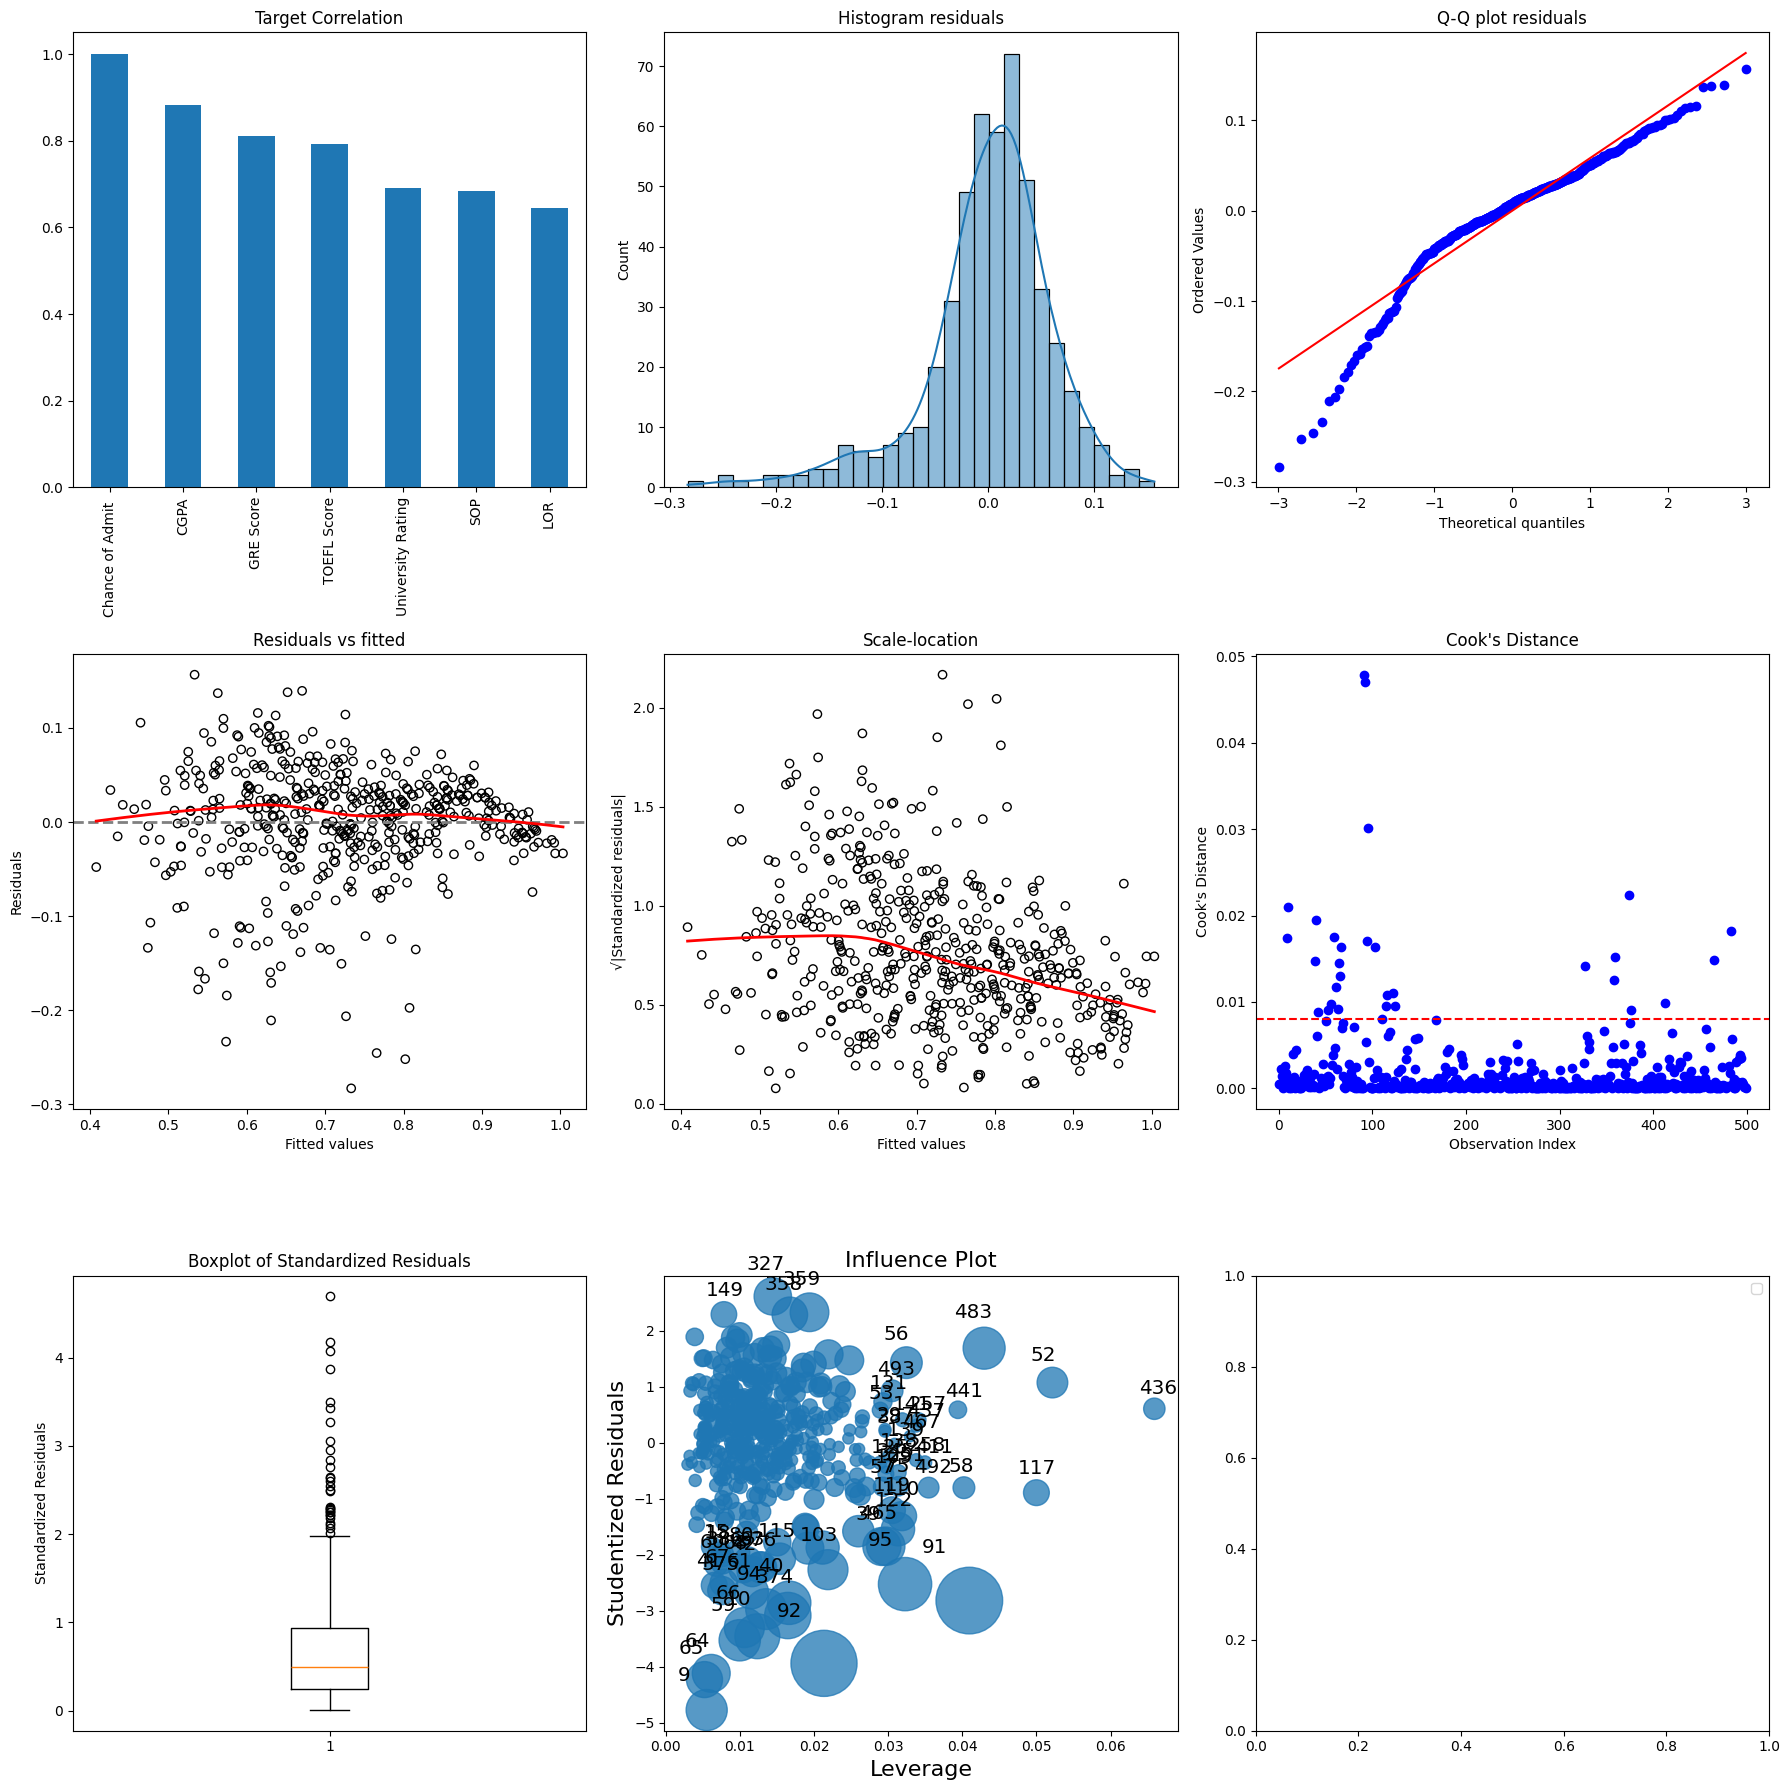

In [11]:
outliers = build_and_analyze_model(df, columns, target_col)

- Liniowa Korelacja między naszym targetem a CGPA i GRE Score, wynosi odpowiednio 0.88 i 0.81. Najmniejsza jest ze zmienną LOR i wynosi 0.64.
- Dopasowany model ma postać funkcyjną \
y = 0.0024 * GRE Score + 0.0026 * TOEFL Score  + 0.0067 * University Rating + 0.0019 * SOP + 0.0177 * LOR + 0.1192 * SOP  + -1.4268 \
i został dopasowany na 500 obserwacjach. 
- Wartości reziduów mają rozkład wizualnie przypominający normalny, z grubszym ogonem z lewej strony (oznacza to lewoskośność, lecz niewielką). Jednak o braku normalności świadczy test **Saphiro-Wilka**, którego p-value < 0.05, zatem odrzucamy hipotezę o normalności reziduów na poziomie 5% istotności. Dodatkowo **QQ-Plot** wykazuje odchyły od normalności - z lewej strony punky nie pokrywają się z linią. Średnia rozkładu jest bardzo bliska zeru, natomiast odchylenie standardowe wynosi ok. 0.06.
- Ujemne **Skewness** (-1.19) wskazuje na lewostronną skośność, co widoczne jest też na histogramie - lewy ogon jest grubszy. **Kurtoza** ma wartość 3 co oznaczałoby
grube ogony w rozkladzie reziduów. \
- Dla wszystkich współczynników regresji mamy hipotezy zerowe H_0 mówiące o tym, że współczynnik jest równy zero. Dla wszystkich wartości t nie wpada w 95%-przedział
ufności, zatem odrzucamy takie hipotezy na rzecz hipotezy H_1 mówiącej o tym, że współczynniki nie są równe 0. **WSZYSTKIE WSPÓŁCZYNNIKI SĄ ISTOTNE STATYSTYCZNIE**.
- **RMSE** wynosi 0.06 co oznacza, że pierwiastek z średniego błędu kwadratowego jest równy 0.06. Innymi słowy można to interpretować, jakbyśmy średnio popełniali błąd 0.06 na każdą z predykcji (średniokwadrtowy + pierwiastek). Jest to akceptowalna wartość, ponieważ zakres wartości wynikowych to [0,1], czyli popełniamy ok 6% błędu. **RSS** wynosi 1.81, to znaczy, że suma wszystkich kwadratów błędów na cały proces dopasowywania wyniosła 1.81.
- **Model wyjaśnia 81.5% wariancji zmiennej y przez zmienne X** ponieważ **Adjusted R^2** = 0.815. W regresji wielorakiej wykorzystujemy Adjusted R2 jako wyznacznik, a nie R2, ponieważ R2 dla rosnącej liczby zmiennych również rośnie, co zaburza rzetelność wyników.
- p-value dla **F-statistic** jest równe 3.22e-178 (< 0.05), co interpretujemy jako niemożliwość wyjaśnienia wartości y za pomocą wzoru y = b. Musimy użyć y = ax + b

- Z wykresu Residuals vs Fitted wynika, że nie zachodzi trend w rozkladzie wartosci reziduów. Wykres uklada sie (raczej!!!) równomiernie
wokół prostej y=0, ale wykazuje pewne rozbieżności.
- Test Levene'a wykazuje p-value=5.159344507392591e-07 (< 0.05), co mówiłoby o heterogeniczności (niejednorodności) w wariacji reziduów. Oznacza to, że mamy zmienne wartości reszt wzdłuż wartości przewidywanych przez model. Rozrzut wartości reszt wokół linii regresji jest stały na zmienny wartościach x (dla róznych przedziałów). Z wykresu Residuals-Fitted widzimy, że dla skrajnych wartości na osi X zauważamy mniejszą wariancję w rozkładzie. Dodatkowo Wykres Scale-location informuje nas, ze pierwiastek z ustandaryzowanych reszt jest zmienny dla wszystkich przedziałów (wartości)
zmiennej niezależnej X (tj. dla wszystkich dopasowanych wartości y). Czerwona linia dopasowania ma trend spadkowy od ok połowy zakresu wszystkich Fitted Values, lecz jest to spowodowane tym, że dla poprzednich obserwacji (ok 0.6 na osi X) istniało dużo wartości wpływowych z dużą wartością pierwiastka z standardized residuals. Gdy ich zabraknie to linia dopasowania może przypominać trend, lecz możemy to ominąć na ten moment. Zostaną one odfiltrowane w przyszłych fazach.

- Istnieje szansa na występowanie autokorelacji reszt składnika losowego, wg testu **Boxa-Pierce'a** (sprawdzającego czy reszty nie są ze sobą skorelowane), ponieważ odrzucamy hipotezy H_0
mówiącej o niewystępowaniu autokorelacji. Na poziomach lag=1,2,3 otrzymujemy p-value z testu Boxa-Pierca: [3.100784e-38 2.338399e-49 1.059268e-52]
które są <0.05. Zatem odrzucamy H_0 na rzecz hipotezy alternatywnej H_1 mówiącej o występowaniu autokorelacji reszt.

- Do nastepnych eksperymentów odrzucamy obserwacje znaczące (wpływowe), tj. dla których **odległość cook'a** była większa od 0.008016032064128256 (na podstawie heurystyki 4/(n-1))

- Statystyka t jest większa od wartości krytycznej dla n-2 stopni swobody, gdzie n jest liczbą obserwacji. Odrzucamy hipotezę zerową, 
że korelacja jest równa 0

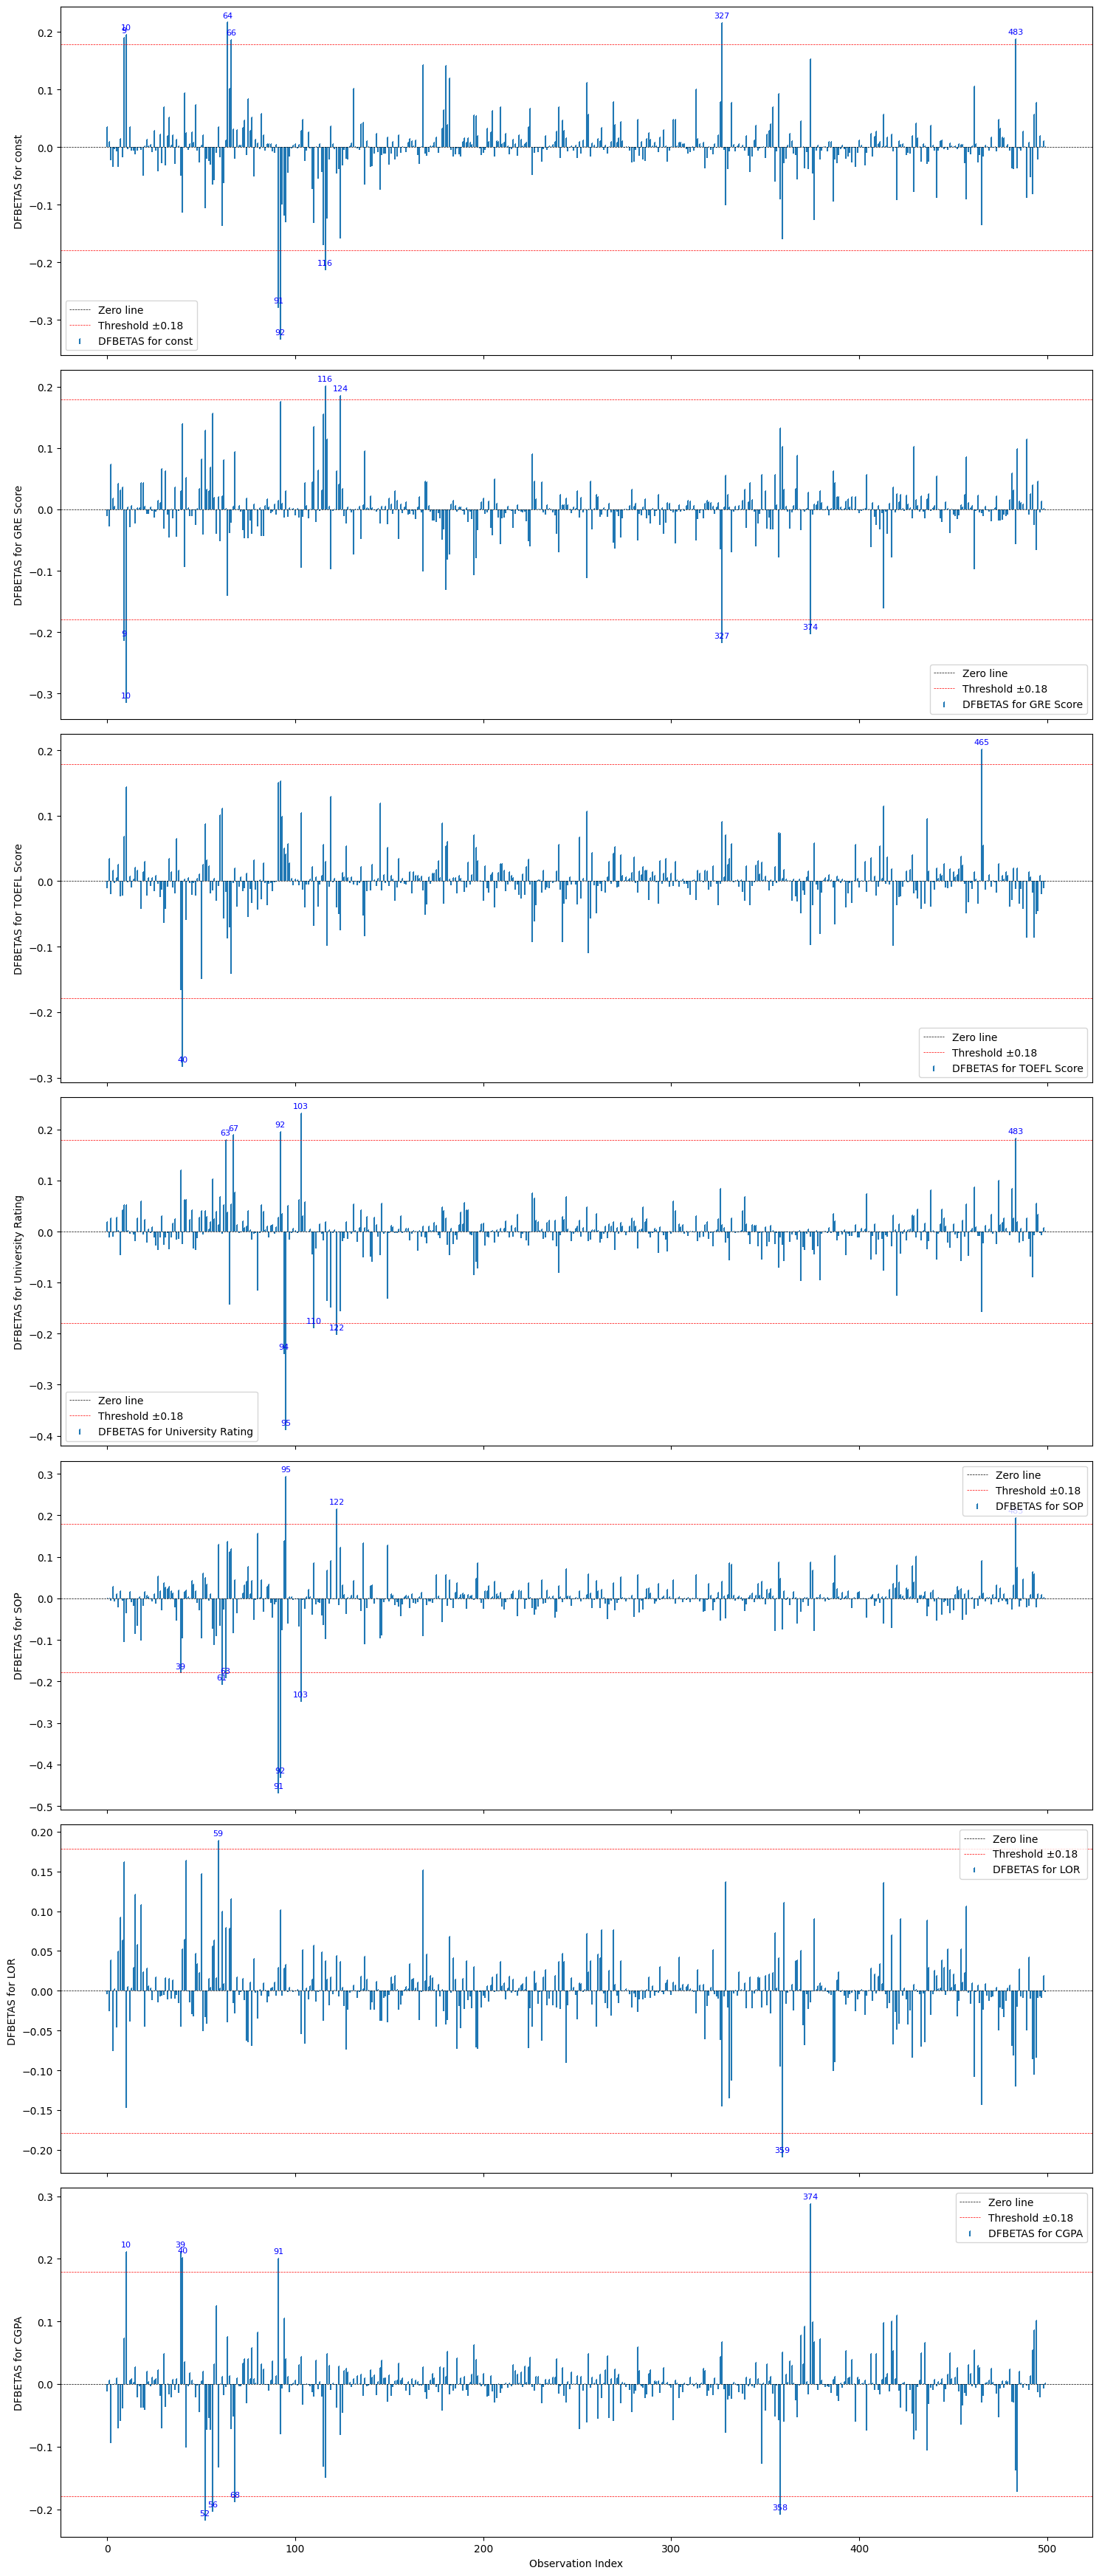

In [15]:
model = sm.OLS(df[target_col], sm.add_constant(df[columns])).fit()

dfbetas = model.get_influence().dfbetas

threshold = 4 / np.sqrt(df.shape[0])
dfbetas_outliers = []

# Plotting DFBETAS
fig, axes = plt.subplots(nrows=dfbetas.shape[1], ncols=1, figsize=(15, 35), sharex=True)
for i in range(dfbetas.shape[1]):
    axes[i].stem(dfbetas[:, i], markerfmt=",", basefmt=" ", label=f'DFBETAS for {sm.add_constant(df[columns]).columns[i]}')
    axes[i].set_ylabel(f'DFBETAS for {sm.add_constant(df[columns]).columns[i]}')
    axes[i].axhline(y=0, color='black', linestyle='--', linewidth=0.5, label='Zero line')
    axes[i].axhline(y=threshold, color='red', linestyle='--', linewidth=0.5, label=f'Threshold ±{threshold:.2f}')
    axes[i].axhline(y=-threshold, color='red', linestyle='--', linewidth=0.5)
    
    # Annotate points above the threshold
    for j, value in enumerate(dfbetas[:, i]):
        if abs(value) > threshold:
            dfbetas_outliers.append(j)
            axes[i].annotate(f'{j}', (j, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='blue')
    
    axes[i].legend(loc='best')
    
axes[-1].set_xlabel('Observation Index')
plt.tight_layout()
plt.show()

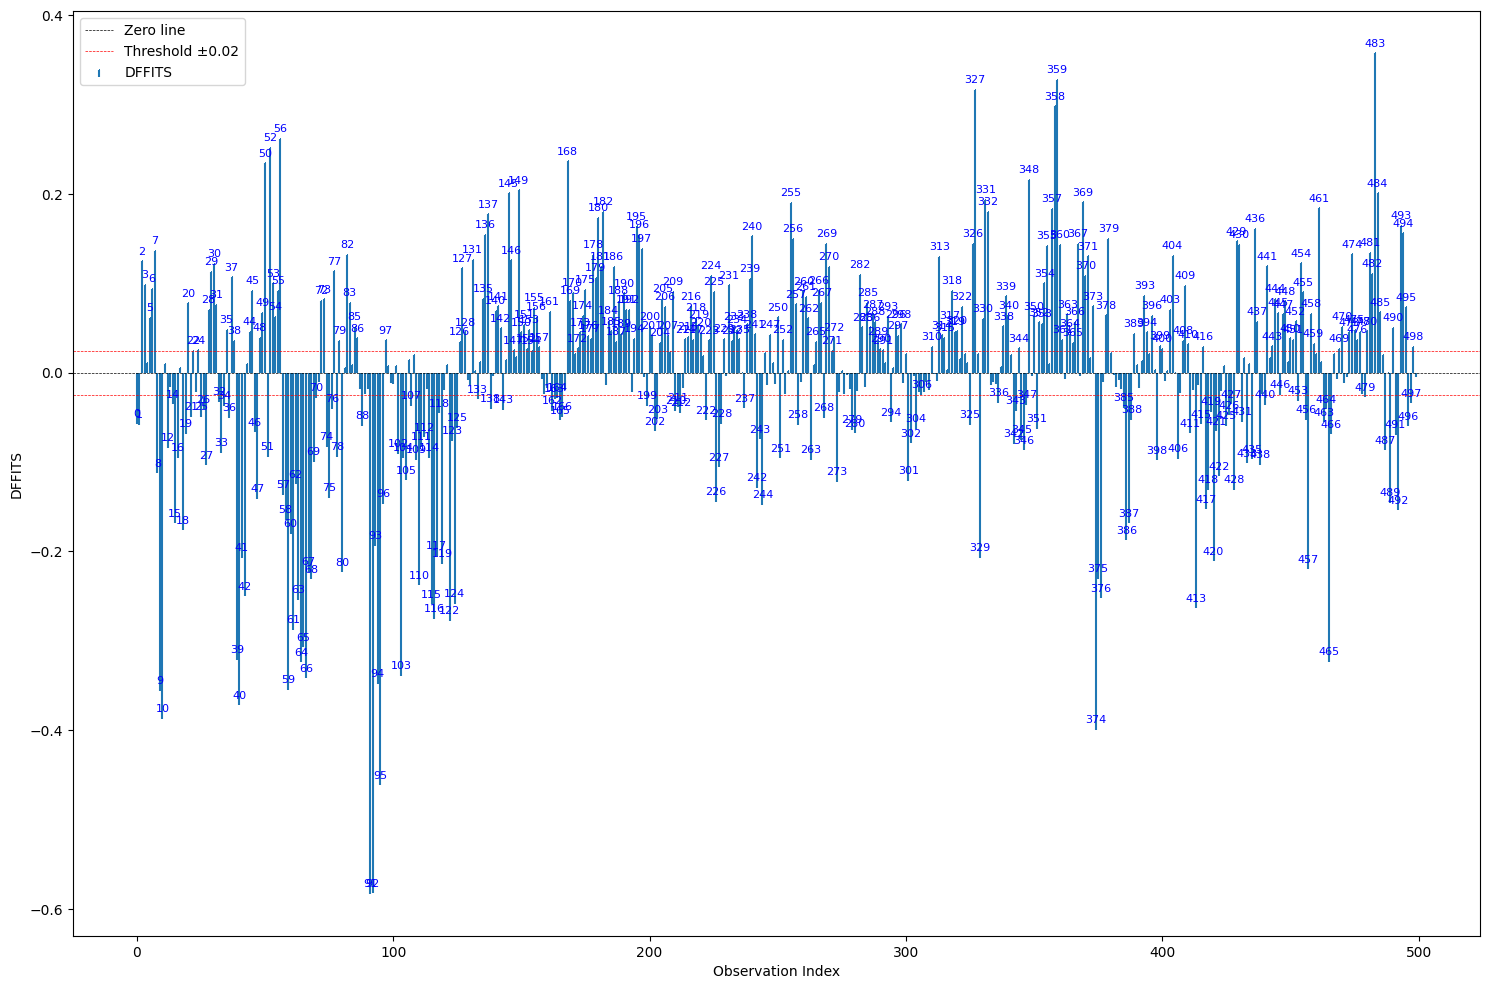

In [14]:
model = sm.OLS(df[target_col], sm.add_constant(df[columns])).fit()

dffits, _ = model.get_influence().dffits

threshold = 4 * np.sqrt(df.shape[1]) / (df.shape[0] - df.shape[1] - 1)

# Plotting DFBETAS
fig, ax = plt.subplots(figsize=(15, 10))
ax.stem(dffits, markerfmt=",", basefmt=" ", label='DFFITS')
ax.set_ylabel('DFFITS')
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5, label='Zero line')
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=0.5, label=f'Threshold ±{threshold:.2f}')
ax.axhline(y=-threshold, color='red', linestyle='--', linewidth=0.5)

# Annotate points above the threshold
for i, value in enumerate(dffits):
    if abs(value) > threshold:
        ax.annotate(f'{i}', (i, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='blue')

ax.legend(loc='best')
ax.set_xlabel('Observation Index')
plt.tight_layout()
plt.show()

### DFFITS i DFBETAS

Powyższe wykresy prezentują wartości DFBETAS oraz DBFITS służące do wykrywania obserwacji wpływowych w modelu. DFBETAS ma podział na obserwacje odstające na każdy z predykatów,
czyli powstało 6 wykresów + 1 na bias modelu. Ustalamy threshold jako 4/sqrt(n), gdzie n to liczba predykatów (celowo zwiększyliśmy threshold w porównaniu do zalecanego licznika równego 2,
ponieważ w innym wypadku ponad połowa obserwacji zostałaby odrzucona). Dla DBFITS widzimy "skumulowany" wykres dla wszystkich zmiennych na raz. Uznaliśmy, że nie będziemy z niego
korzystać, ponieważ obserwujemy zbyt duże odchyły, co znowu spowoduje odsianie większej części punktów danych (nawet po zwiększeniu thresholdu dwukrotnie). 


In [21]:
# outlierzy z DFBETAS
dfbetas_outliers
# odfiltrujemy je w drugiej następnej fazie (tj. w 2. filtracji - patrz poniżej)

[9,
 10,
 64,
 66,
 91,
 92,
 116,
 327,
 483,
 9,
 10,
 116,
 124,
 327,
 374,
 40,
 465,
 63,
 67,
 92,
 94,
 95,
 103,
 110,
 122,
 483,
 39,
 61,
 63,
 91,
 92,
 95,
 103,
 122,
 483,
 59,
 359,
 10,
 39,
 40,
 52,
 56,
 68,
 91,
 358,
 374]

<center>
<h5>
Teraz wykonamy eksperymenty dla tych samych zmiennych, ale z odfiltrowanymi obserwacjami wpływowymi na podstawie odległości cooka
</h5>
</center>



========== Correlation: ==========

Pearson correlation coefficient between X and y: Chance of Admit      1.000000
CGPA                 0.918762
GRE Score            0.847684
TOEFL Score          0.824686
University Rating    0.745742
SOP                  0.743945
LOR                  0.669806
Name: Chance of Admit , dtype: float64


========== Model summary description: ==========
                            OLS Regression Results                            
Dep. Variable:       Chance of Admit    R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     577.1
Date:                Sat, 08 Jun 2024   Prob (F-statistic):          4.94e-211
Time:                        10:53:38   Log-Likelihood:                 780.23
No. Observations:                 469   AIC:                            -1546.
Df Residuals:                     462   BIC:                

count    4.690000e+02
mean     6.093207e-16
std      4.589148e-02
min     -1.691721e-01
25%     -2.566229e-02
50%      3.224077e-03
75%      2.824311e-02
max      1.288107e-01
dtype: float64



========== Residual normality check: ==========
Shapiro-Wilk test p-value: 8.653405695744733e-07


========== Residual skewness check: ==========
Skewness: -0.5717016285998555


========== Residual kurtosis check: ==========
Kurtosis: 1.1592769719313956


========== Homoscedasticity check: ==========
Levene's test p-value: 7.819215001435095e-09


========== Autocorrelation check (for lags=1,2,3): ==========


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,70.888727,3.779514e-17,70.437207,4.751526e-17
2,85.379393,2.884699e-19,84.804809,3.844764e-19
3,89.207766,3.241232e-19,88.592541,4.393741e-19


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Box-Pierce test statistic: [70.43720652 84.80480921 88.5925415 ]
Box-Pierce test p-value: [4.75152628e-17 3.84476377e-19 4.39374066e-19]


========== Outliers list: ==========

Indices of outliers based on cooks distance (beyond threshold 0.008547008547008548): [ 13  16  37  45  50  51  52  54  55  67  78  96  98 122 126 145 305 324
 348 358 388 391 428 453 461]


========== Correlation coefficient statistical significance: ==========
Statystyka t: 55.56866627815225 
Wartość krytyczna (górna): 1.9650567615410266


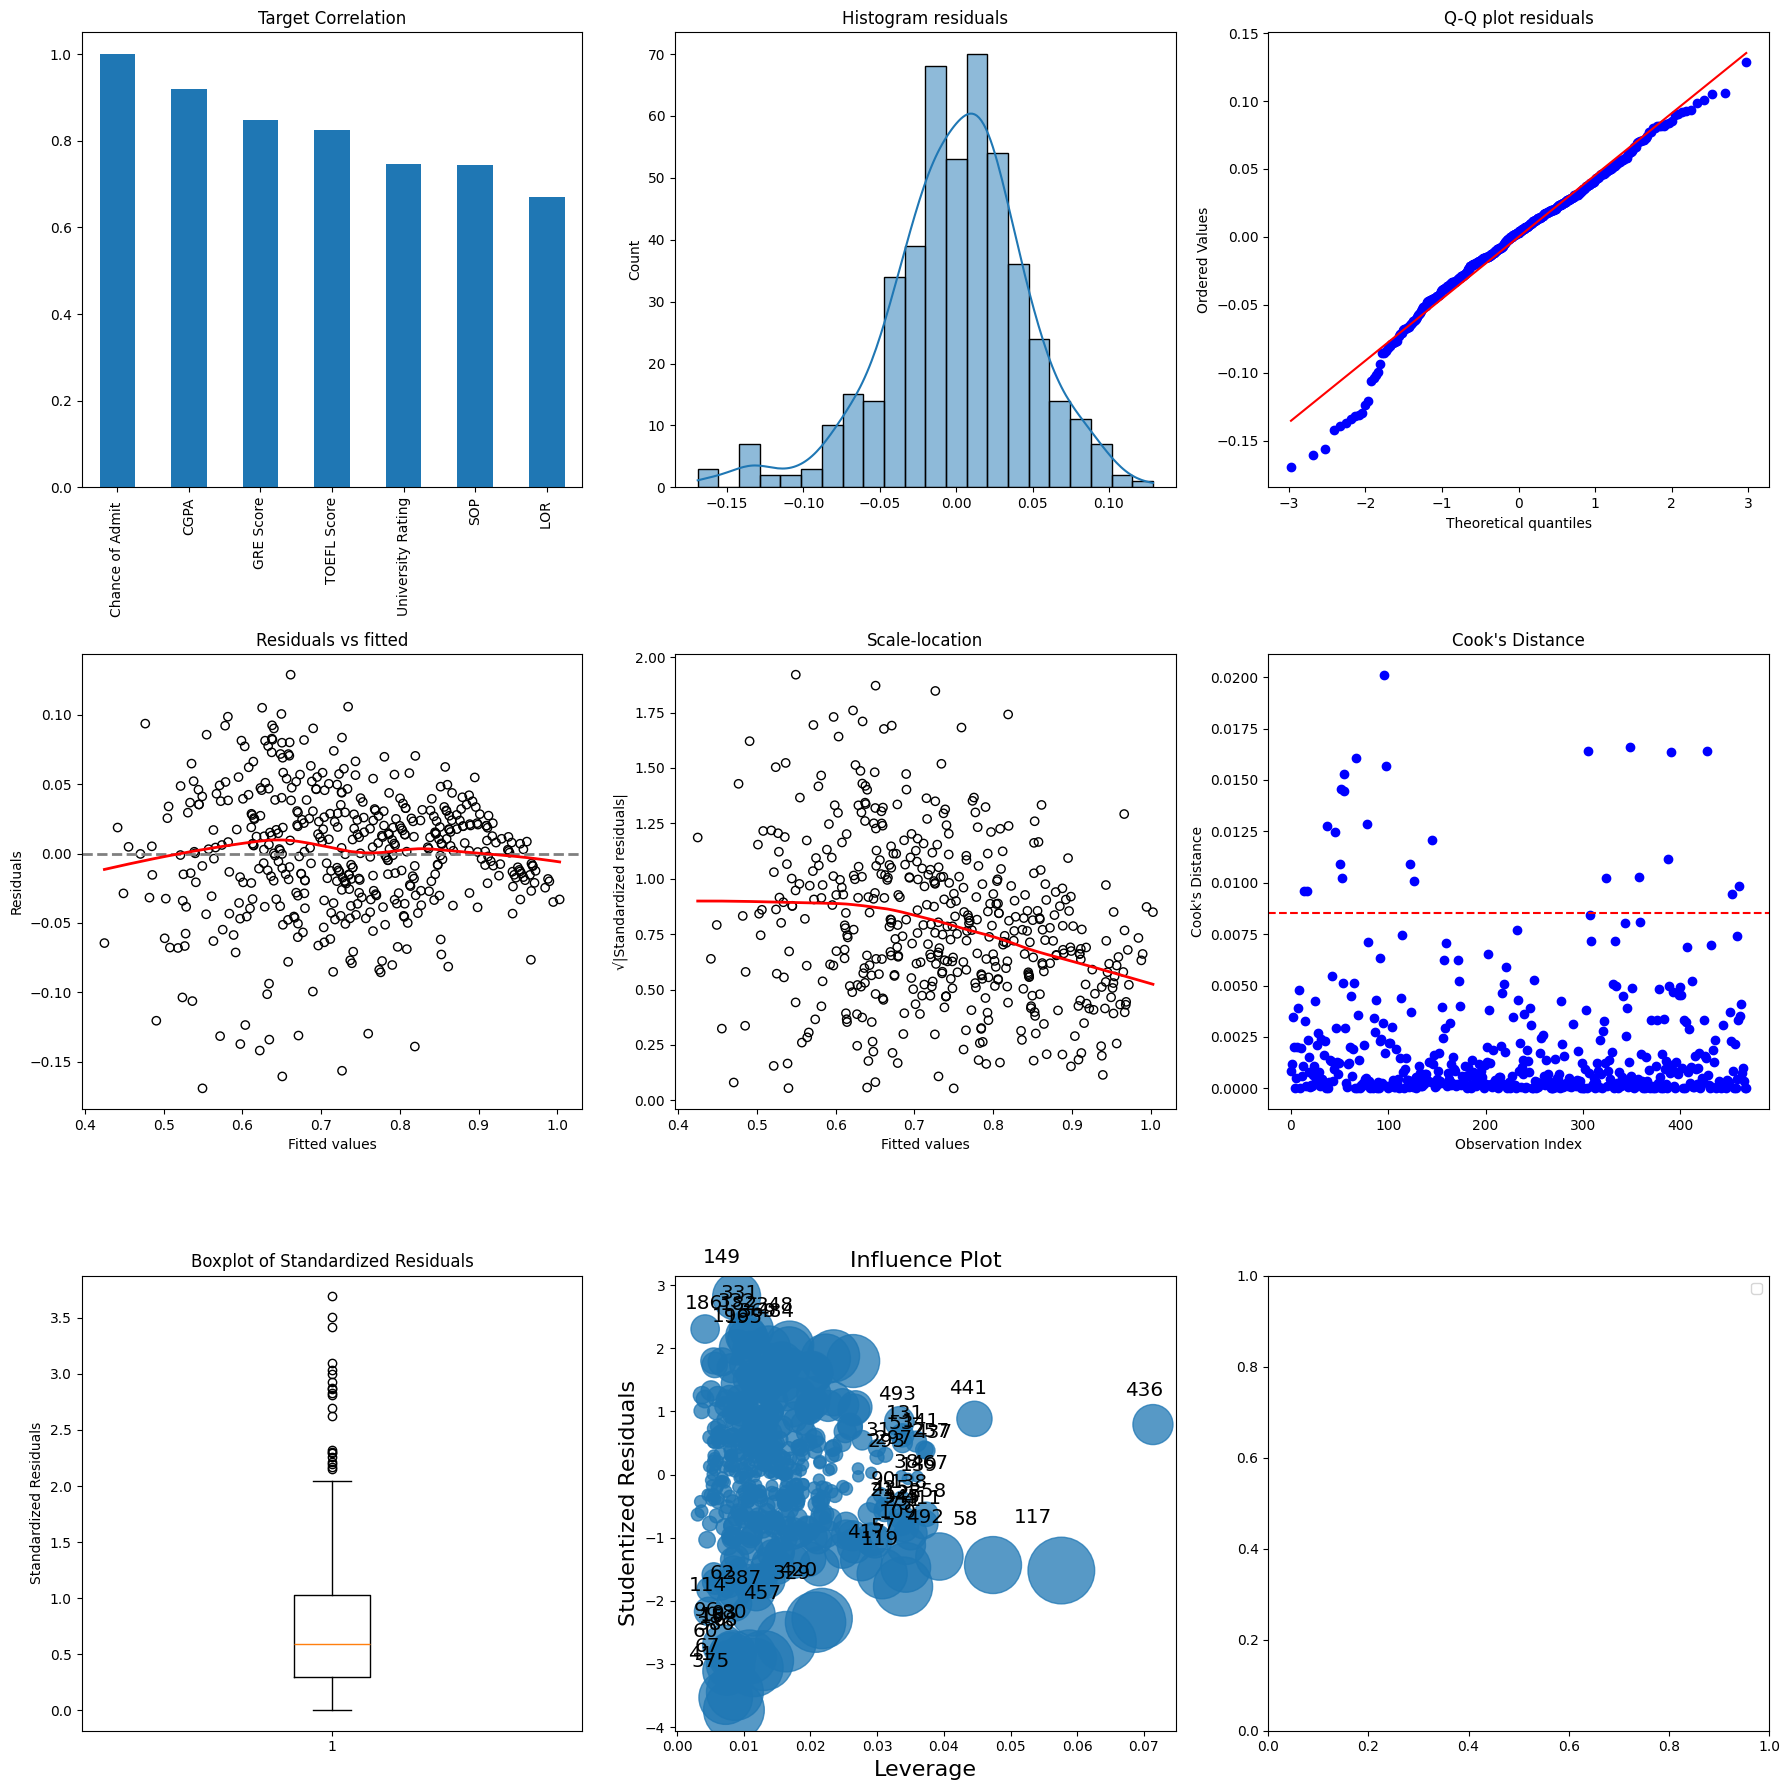

array([ 13,  16,  37,  45,  50,  51,  52,  54,  55,  67,  78,  96,  98,
       122, 126, 145, 305, 324, 348, 358, 388, 391, 428, 453, 461],
      dtype=int64)

In [22]:
df_filtered = df.drop(outliers)
build_and_analyze_model(df_filtered, columns, target_col)

Jak widać :
- QQ plot przyjął teraz bardziej liniowy kształt, ale model wciąż nie przechodzi testu Saphiro-Wilka, p-value jest wciąż mniejsze od 0.05. Mimo to zauważamy, że kształt rozkładu reziduów jest dużo bardziej zbliżony do normalnego. Histogram reszt nie jest juz (aż tak) lewoskośny (nie ma obserwacji odstających w prawym ogonie). **Skewness** wzrosło i jest bliższe 0, **Kurtoza** zmalała, czyli nie widzimy już tak grubych ogonów. 
- **Influence plot** wciąż posiada jednak wartości wpływowe (436, 114, 58, 441), ale **Wykres odległosci Cooka** wygląda już dużo lepiej, wartości już tak nie odstają.
- **box plot** nie ma tak zróżnicowanych wartości, chociaz jeszcze zostało sporo outlierów z prawej strony rozkładu reziduów., 
- **Residuals vs fitted** ma troche mniej zróżnicowany rozkład, czyli wariancja się zmniejszyła. Analogiczna sytuacja dla **Scale-Location**, chociaż trend w ustandaryzowanych reziduach jest wciąż widoczny.
- Model wciąz nie przechodzi testów **Saphiro-Wilka**, **Levene'a** i **Box-pierce'a**
- Mimo wszystko wszystkie metryki znacząco się poprawiły - R2 i Adjusted R2 wzrosło z 0.82 do 0.88, RMSE spadło z 0.06 do 0.04


Odfiltrujemy jeszcze raz, tym razem z odrzuceniem wartosci wpływowych widocznych z wykresu **Influenece Plot** ORAZ z usunięciem punktów danych z **DFBETAS**

In [24]:
dfbetas_outliers

[9,
 10,
 64,
 66,
 91,
 92,
 116,
 327,
 483,
 9,
 10,
 116,
 124,
 327,
 374,
 40,
 465,
 63,
 67,
 92,
 94,
 95,
 103,
 110,
 122,
 483,
 39,
 61,
 63,
 91,
 92,
 95,
 103,
 122,
 483,
 59,
 359,
 10,
 39,
 40,
 52,
 56,
 68,
 91,
 358,
 374]

Usuwamy następujące indeksy:  [  9  10  39  40  42  52  56  58  59  61  63  64  65  66  67  68  91  92
  94  95 103 110 114 115 116 122 124 327 358 359 374 376 413 436 441 465
 483]


========== Correlation: ==========

Pearson correlation coefficient between X and y: Chance of Admit      1.000000
CGPA                 0.922656
GRE Score            0.850155
TOEFL Score          0.829485
SOP                  0.755074
University Rating    0.747525
LOR                  0.672404
Name: Chance of Admit , dtype: float64


========== Model summary description: ==========
                            OLS Regression Results                            
Dep. Variable:       Chance of Admit    R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     594.8
Date:                Sat, 08 Jun 2024   Prob (F-statistic):          4.74e-212
Time:                        10:56:1

count    4.630000e+02
mean    -2.504836e-15
std      4.471601e-02
min     -1.690467e-01
25%     -2.466140e-02
50%      3.110449e-03
75%      2.713513e-02
max      1.264490e-01
dtype: float64



========== Residual normality check: ==========
Shapiro-Wilk test p-value: 8.079634092792532e-06


========== Residual skewness check: ==========
Skewness: -0.505861345248396


========== Residual kurtosis check: ==========
Kurtosis: 1.1038252198988494


========== Homoscedasticity check: ==========
Levene's test p-value: 7.4127676854274395e-09


========== Autocorrelation check (for lags=1,2,3): ==========


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,60.203106,8.555707e-15,59.814699,1.042220e-14
2,68.553049,1.299854e-15,68.092814,1.636188e-15
3,69.385406,5.779015e-15,68.916221,7.282887e-15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Box-Pierce test statistic: [59.81469916 68.0928142  68.91622105]
Box-Pierce test p-value: [1.04222043e-14 1.63618824e-15 7.28288657e-15]


========== Outliers list: ==========

Indices of outliers based on cooks distance (beyond threshold 0.008658008658008658): [ 13  16  37  45  50  51  64  75  92  94 118 122 141 301 303 320 344 354
 355 384 387 422 447 455]


========== Correlation coefficient statistical significance: ==========
Statystyka t: 56.562104834742705 
Wartość krytyczna (górna): 1.9651232162743544


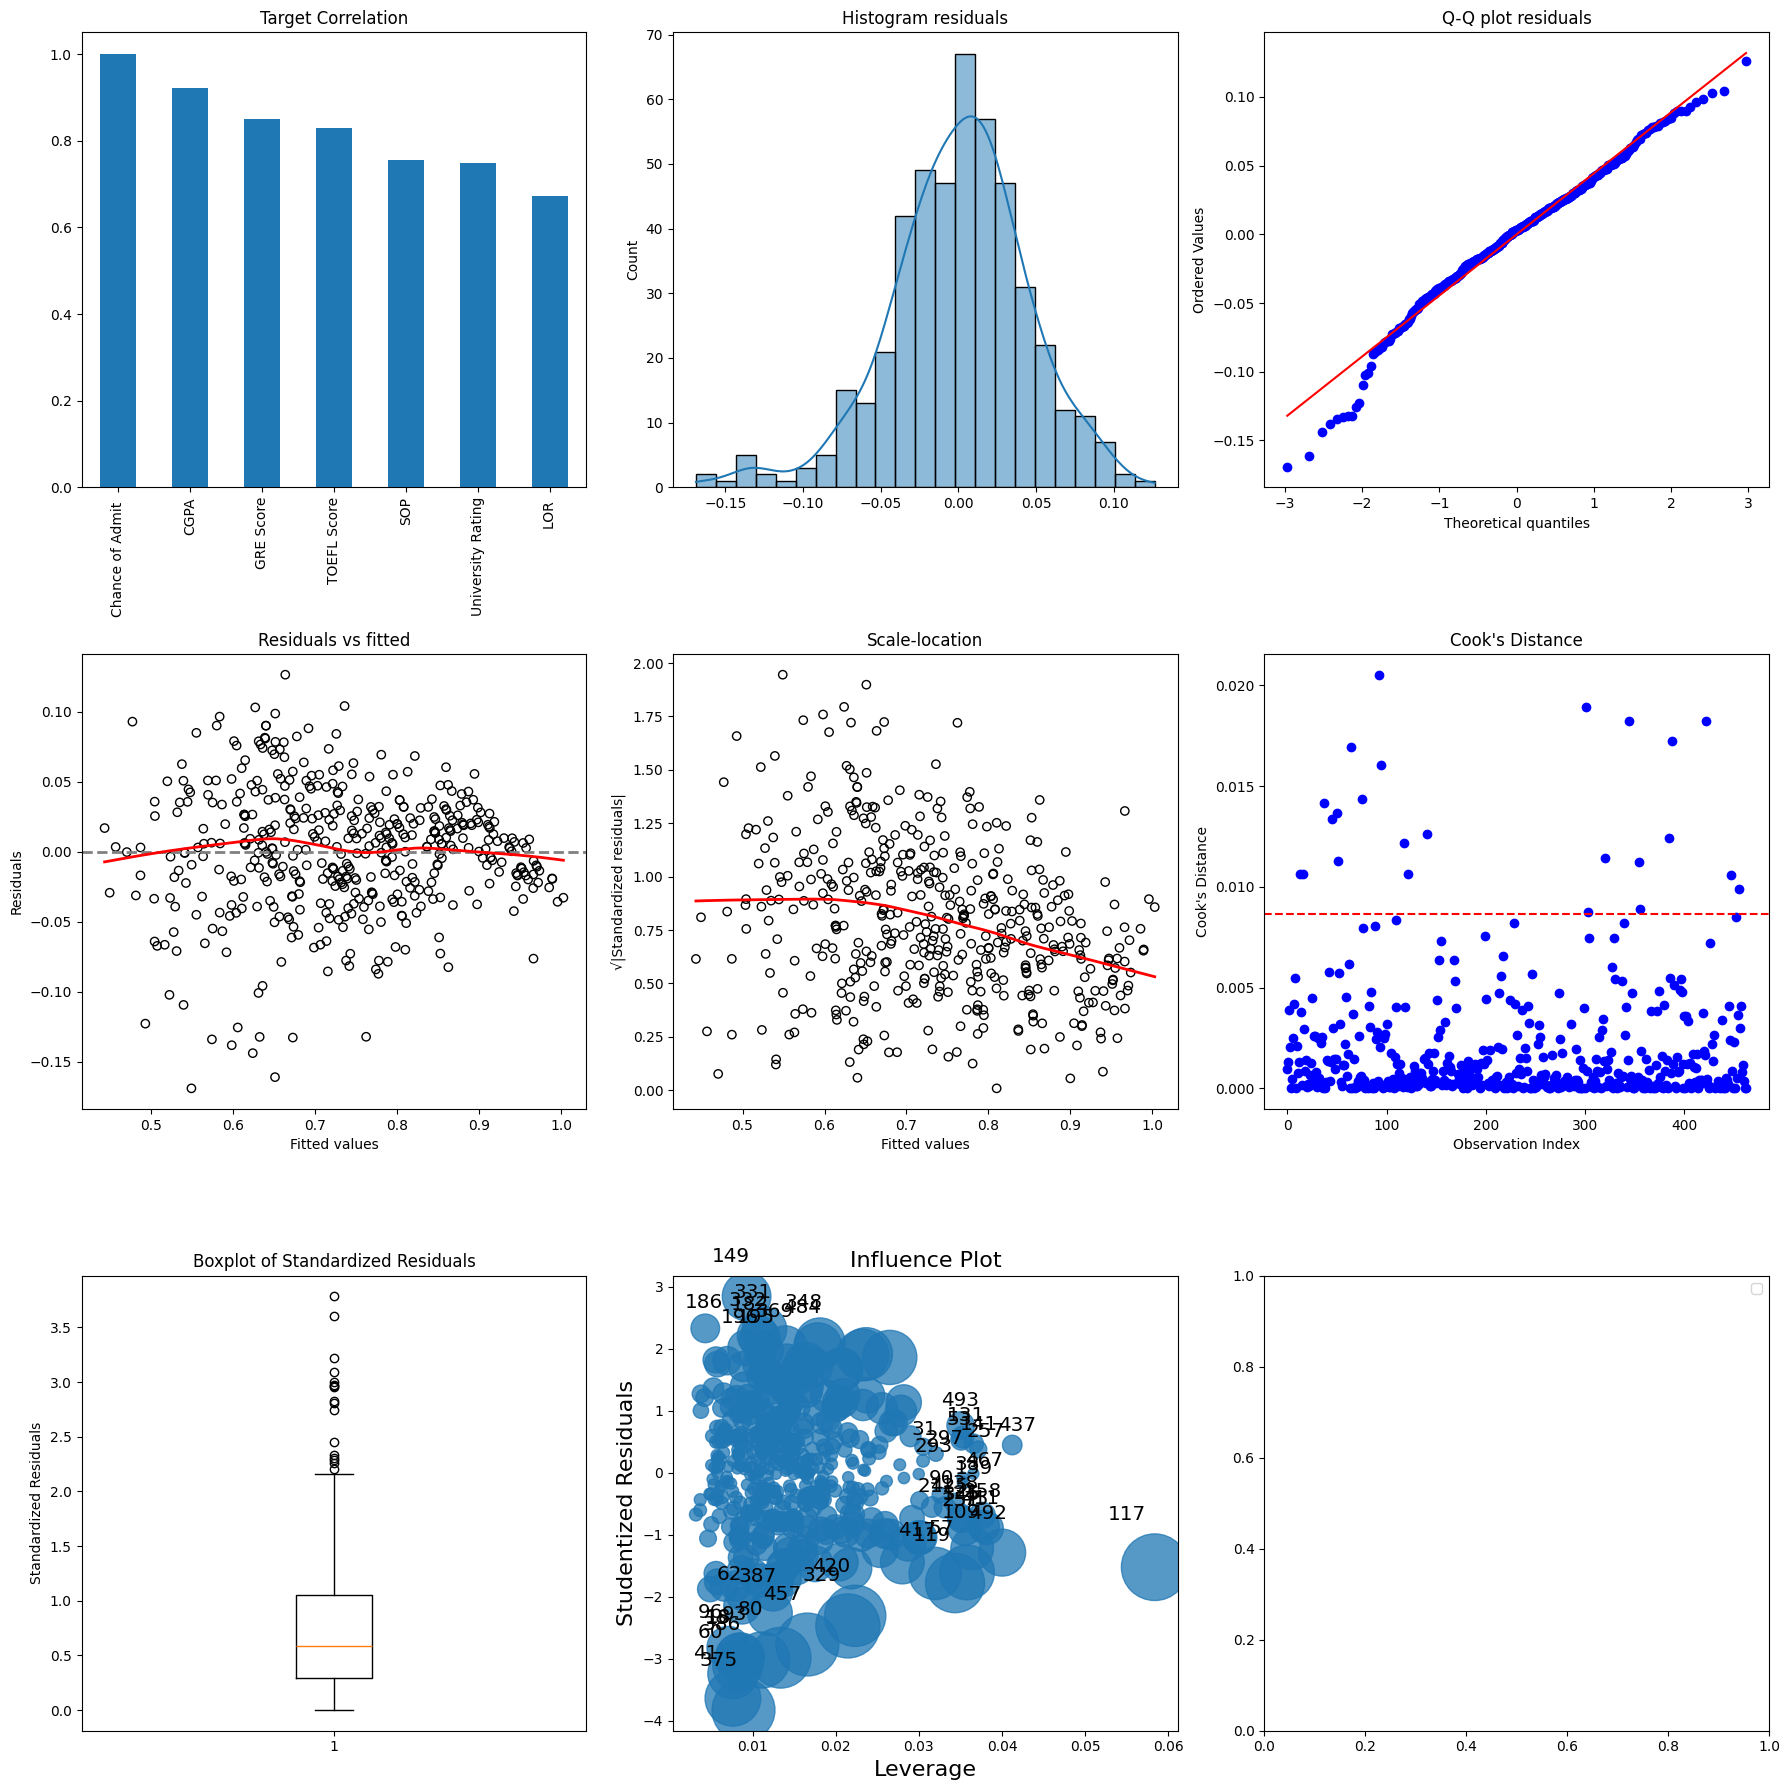

array([ 13,  16,  37,  45,  50,  51,  64,  75,  92,  94, 118, 122, 141,
       301, 303, 320, 344, 354, 355, 384, 387, 422, 447, 455], dtype=int64)

In [28]:
outliers_concatenated = np.unique(np.concatenate((outliers,np.array([436, 114, 58, 441]), dfbetas_outliers)))

print("Usuwamy następujące indeksy: ", outliers_concatenated)

df_filtered = df.drop(outliers_concatenated)
build_and_analyze_model(df_filtered, columns, target_col)

### Żadna z wartości nie zmieniła się znacząco, ale niektóre nieco się poprawily (np. **Skewness**). Odfiltrowanie nie dało zbyt dużo do ostatecznych wyników

In [30]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score

def cross_validate_ols(df, x_cols, y_col, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    r2_scores = []
    rmse_scores = []

    for train_index, test_index in kf.split(df):
        X_train, X_test = df[x_cols].iloc[train_index], df[x_cols].iloc[test_index]
        y_train, y_test = df[y_col].iloc[train_index], df[y_col].iloc[test_index]

        X_train = sm.add_constant(X_train)
        model = sm.OLS(y_train, X_train)
        model_results = model.fit()

        X_test = sm.add_constant(X_test)
        y_pred =  model_results.predict(X_test).values
        y_test = y_test.values.reshape(-1)

        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

        residuals = y_test - y_pred

        rmse = np.sqrt(np.mean(residuals ** 2))
        rmse_scores.append(rmse)

    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmse_scores)

    return mean_r2, mean_rmse

In [31]:
cv_r2, cv_rse = cross_validate_ols(df_filtered, columns, target_col)
print(f"R2 for 5-fold cross validation: {cv_r2} \nRMSE for 5-fold cross validation: {cv_rse}")

R2 for 5-fold cross validation: 0.8825739079000063 
RMSE for 5-fold cross validation: 0.045135544220963254


# Redukcja wymiarowości - Metoda Variance Inflation Factor

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = sm.add_constant(df[columns])
vif_columns = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns).sort_values(ascending=False).iloc[1:]
print(vif_columns)

CGPA                 4.775198
GRE Score            4.099486
TOEFL Score          3.895301
SOP                  2.834057
University Rating    2.613004
LOR                  2.027346
dtype: float64


In [33]:
for col in vif_columns.index:
    print(f"\n\nCROSSVALIDATION RESULTS WHEN COLUMN `{col}` EXCLUDED:")
    cv_r2, cv_rse = cross_validate_ols(df_filtered, [c for c in columns if c not in [col]], target_col)
    print(f"R2 for 5-fold cross validation: {cv_r2} \nRMSE for 5-fold cross validation: {cv_rse}")



CROSSVALIDATION RESULTS WHEN COLUMN `CGPA` EXCLUDED:
R2 for 5-fold cross validation: 0.8277687713871472 
RMSE for 5-fold cross validation: 0.05479314116974138


CROSSVALIDATION RESULTS WHEN COLUMN `GRE Score` EXCLUDED:
R2 for 5-fold cross validation: 0.8748066975920198 
RMSE for 5-fold cross validation: 0.046610640353025284


CROSSVALIDATION RESULTS WHEN COLUMN `TOEFL Score` EXCLUDED:
R2 for 5-fold cross validation: 0.8806169588865677 
RMSE for 5-fold cross validation: 0.0454862763733208


CROSSVALIDATION RESULTS WHEN COLUMN `SOP` EXCLUDED:
R2 for 5-fold cross validation: 0.8820686380497937 
RMSE for 5-fold cross validation: 0.0452197708641949


CROSSVALIDATION RESULTS WHEN COLUMN `University Rating` EXCLUDED:
R2 for 5-fold cross validation: 0.8809629980652334 
RMSE for 5-fold cross validation: 0.04543997961980312


CROSSVALIDATION RESULTS WHEN COLUMN `LOR ` EXCLUDED:
R2 for 5-fold cross validation: 0.877725346013705 
RMSE for 5-fold cross validation: 0.046032970402696195


### Każdy z czynników ma wartość <5, jednakże spróbowaliśmy usuwać po jednym wymiarze, aby sprawdzić jak będzie on wpływał na wynik. 
### Wyniki pokazały, że dla usunięcia predyktora z największym VIF otrzymujemy najgorsze wyniki.

# Redukcja wymiarowości - Metoda z usuwaniem wysoko skorelowanych kolumn

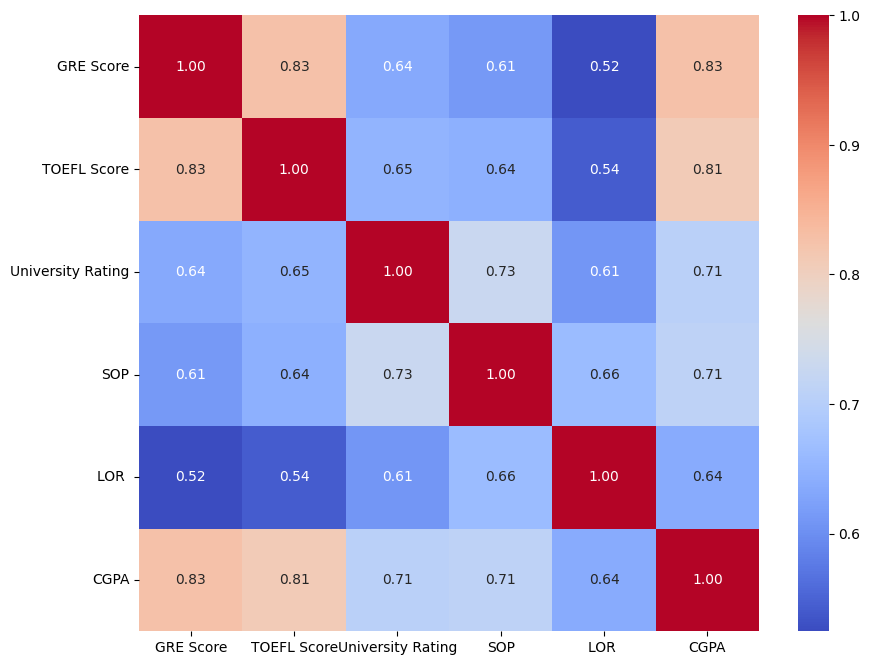

In [34]:
plot_corr(df[columns])

### Widać, że `TOEFL Score`, `GRE Score` oraz `CGPA` są ze sobą mocno skorelowane. Spróbujemy usunąć najpierw po jednym z nich, a potem dwójkami.

In [35]:
print("All columns: ", columns, "\n\n")

print("__Wyniki dla usunięcia pojedynczych kolumn:__")
for c in ['GRE Score', 'TOEFL Score', "CGPA"]:
    modelling_cols = [col for col in columns if col != c]
    print("\tModelling Columns: ", modelling_cols)
    cv_r2, cv_rse = cross_validate_ols(df_filtered, modelling_cols, target_col)
    print(f"\tR2 for 5-fold cross validation: {cv_r2} \n\tRMSE for 5-fold cross validation: {cv_rse}\n")

print("__Wyniki dla usunięcia kolumn parami:__")
for c in [('GRE Score', 'TOEFL Score'), ('GRE Score', "CGPA"), ('TOEFL Score', "CGPA")]:
    modelling_cols = [col for col in columns if col not in c]
    print("\tModelling Columns: ", modelling_cols)
    cv_r2, cv_rse = cross_validate_ols(df_filtered, modelling_cols, target_col)
    print(f"\tR2 for 5-fold cross validation: {cv_r2} \n\tRMSE for 5-fold cross validation: {cv_rse}")

All columns:  ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA'] 


__Wyniki dla usunięcia pojedynczych kolumn:__
	Modelling Columns:  ['TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA']
	R2 for 5-fold cross validation: 0.8748066975920198 
	RMSE for 5-fold cross validation: 0.046610640353025284

	Modelling Columns:  ['GRE Score', 'University Rating', 'SOP', 'LOR ', 'CGPA']
	R2 for 5-fold cross validation: 0.8806169588865677 
	RMSE for 5-fold cross validation: 0.0454862763733208

	Modelling Columns:  ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ']
	R2 for 5-fold cross validation: 0.8277687713871472 
	RMSE for 5-fold cross validation: 0.05479314116974138

__Wyniki dla usunięcia kolumn parami:__
	Modelling Columns:  ['University Rating', 'SOP', 'LOR ', 'CGPA']
	R2 for 5-fold cross validation: 0.8674721369705068 
	RMSE for 5-fold cross validation: 0.047905393888482764
	Modelling Columns:  ['TOEFL Score', 'University Rating', 'SOP', 'LOR ']
	R2

### Wyniki są na ogół gorsze od baseline'owych. Jedynie przy usunięciu pojedynczej cechy `TOEFL Score` można zauważyć bardzo zbliżone wyniki do baseline, jednak są one nieco lepsze. Jeżeli dla danego modelowania ważne jest użycie jak najmniejszej liczby cech, to warto usunąc tą właśnie cechę.

# Redukcja wymiarowości - Metoda Regresji krokowej w przód

In [ ]:
!pip install stepwise-regression

In [36]:
model = sm.OLS(df_filtered[target_col], sm.add_constant(pd.DataFrame(df_filtered[columns]))).fit()
# use all coefs except intercept
pvalues = model.pvalues.iloc[1:]

In [37]:
from stepwise_regression.step_reg import backward_regression
# kod z repozytorium: https://github.com/AakkashVijayakumar/stepwise-regression/blob/master/stepwise_regression/step_reg.py

columns_included = backward_regression(X=df_filtered[columns],  y=df_filtered[target_col], threshold_out=0.05, verbose=True)

print(f"Feature Selection z użyciem metody regresji krokowej w tył wykazał zostawienie kolumn: {columns_included} z kryterium na p-value. \n\
Odrzucone zostały kolumny, których p-value przekraczało `threshold_out` czyli 0.05")

Drop SOP                            with p-value 0.0748958
Feature Selection z użyciem metody regresji krokowej w tył wykazał zostawienie kolumn: ['GRE Score', 'TOEFL Score', 'University Rating', 'LOR ', 'CGPA'] z kryterium na p-value. 
Odrzucone zostały kolumny, których p-value przekraczało `threshold_out` czyli 0.05


In [38]:
cv_r2, cv_rse = cross_validate_ols(df_filtered, columns_included, target_col)
print(f"R2 for 5-fold cross validation: {cv_r2} \nRMSE for 5-fold cross validation: {cv_rse}")

R2 for 5-fold cross validation: 0.8820686380497937 
RMSE for 5-fold cross validation: 0.0452197708641949


### Metoda regresji krokowej w tyl wykazała, że usunięcie kolumny SOP przyniesie nam największe korzyści. Po weryfikacji wyników na 5-fold CV widzimy, że
### faktycznie osiągnięte wyniki są wysokie, lecz nie jest to wynik, który bardzo odbiega od wyników osiąganych z użyciem wszystkim kolumn. Niemniej jednak
### warto usunąć tą kolumnę przy modelowaniu, ponieważ model zostaje uproszczony.

# Wnioski i podsmuowanie
